# Student-t Process

PyMC3 also includes T-process priors.  They are a generalization of a Gaussian process prior to the multivariate Student's T distribution.  The usage is identical to that of `gp.Latent`, except they require a degrees of freedom parameter when they are specified in the model.  For more information, see chapter 9 of [Rasmussen+Williams](http://www.gaussianprocess.org/gpml/), and [Shah et al.](https://arxiv.org/abs/1402.4306).

Note that T processes aren't additive in the same way as GPs, so addition of `TP` objects are not supported.

## Samples from a TP prior

The following code draws samples from a T process prior with 3 degrees of freedom and a Gaussian process, both with the same covariance matrix. 

In [1]:
import aesara
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy as sp

You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3


In [17]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 4300
rng = aesara.shared(np.random.default_rng(RANDOM_SEED))
#rng_a = aesara.shared(rng)

az.style.use("arviz-darkgrid")

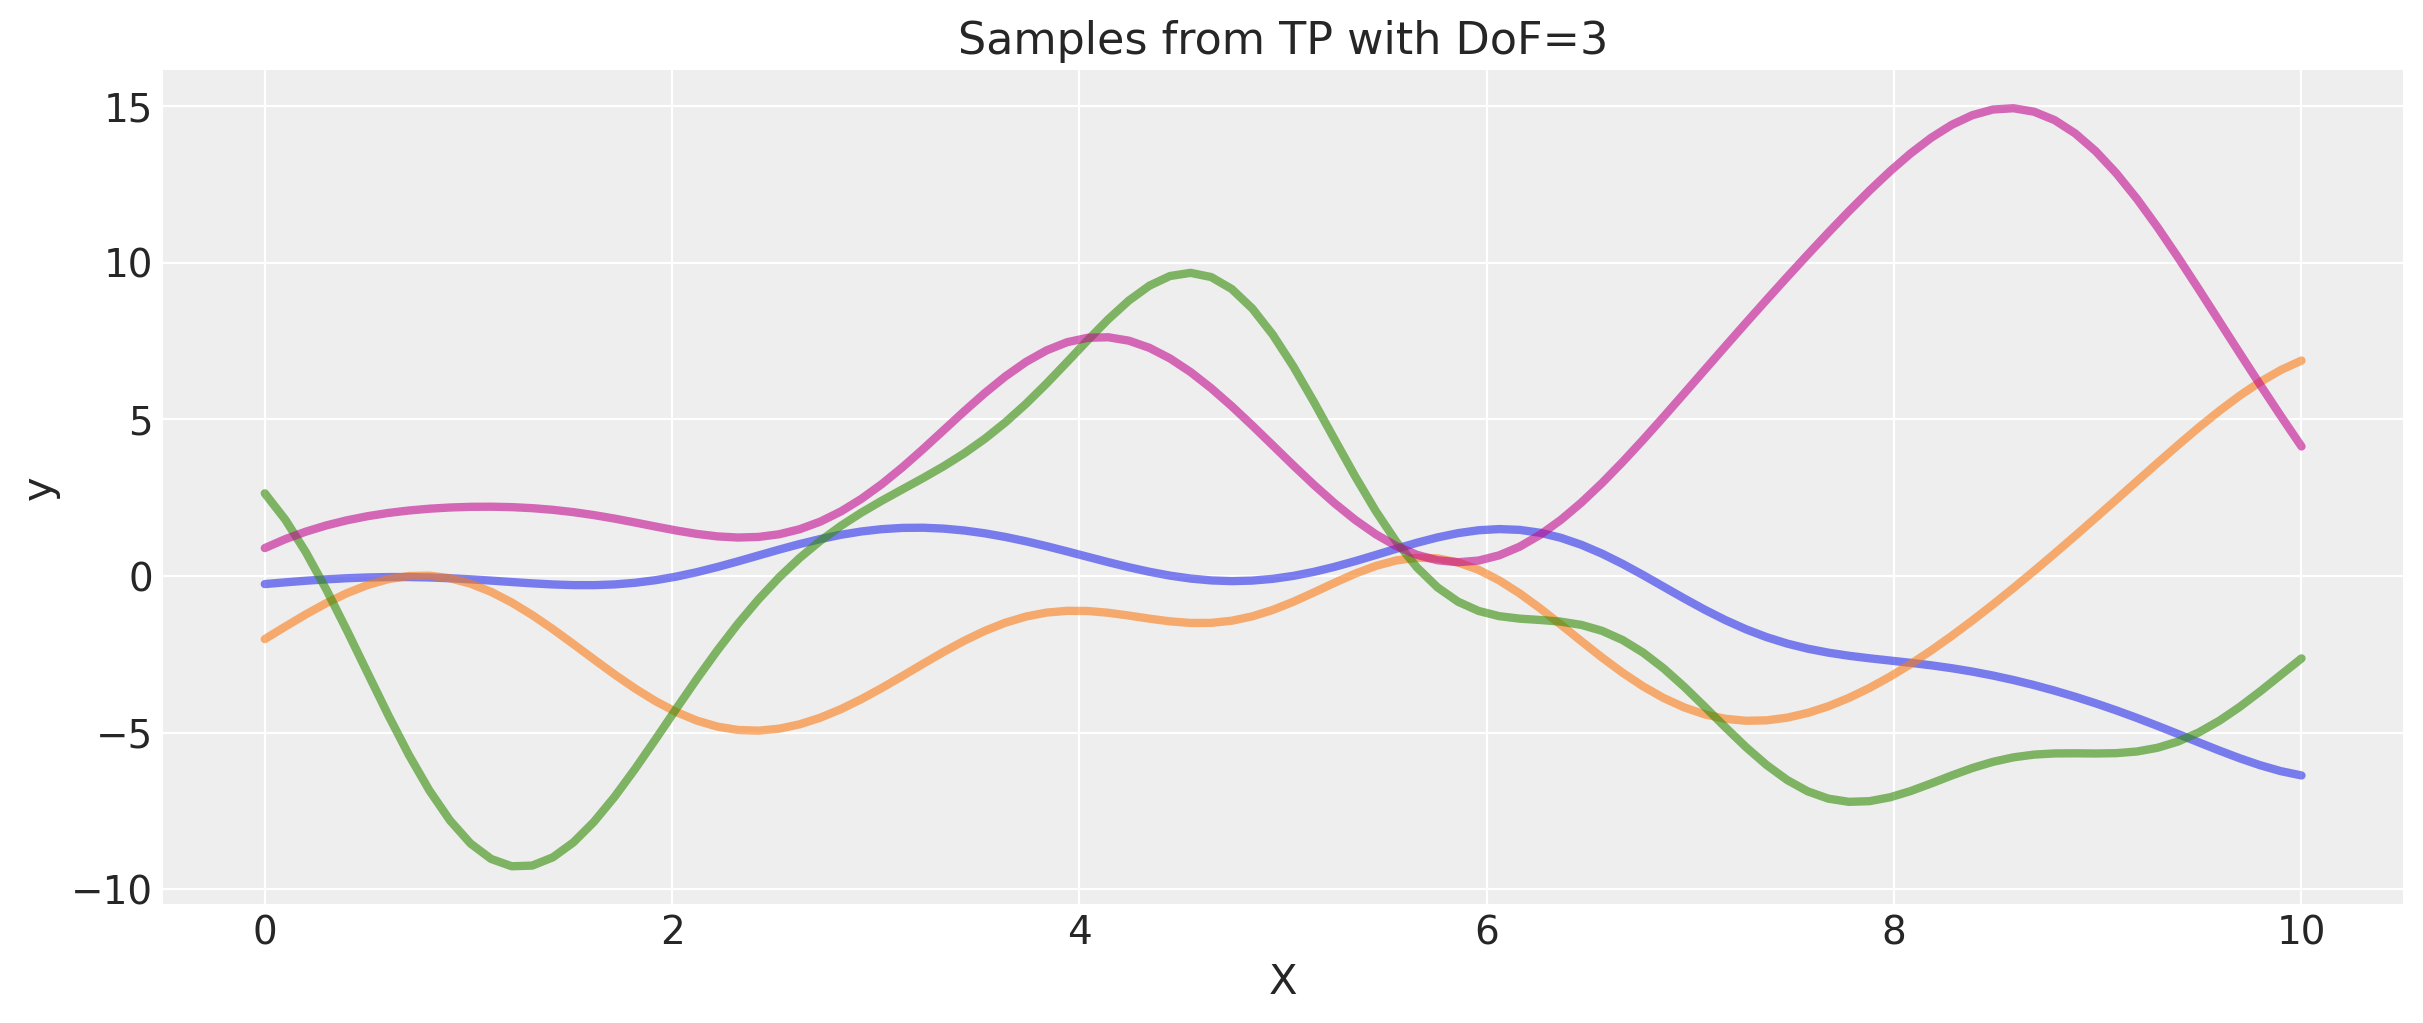

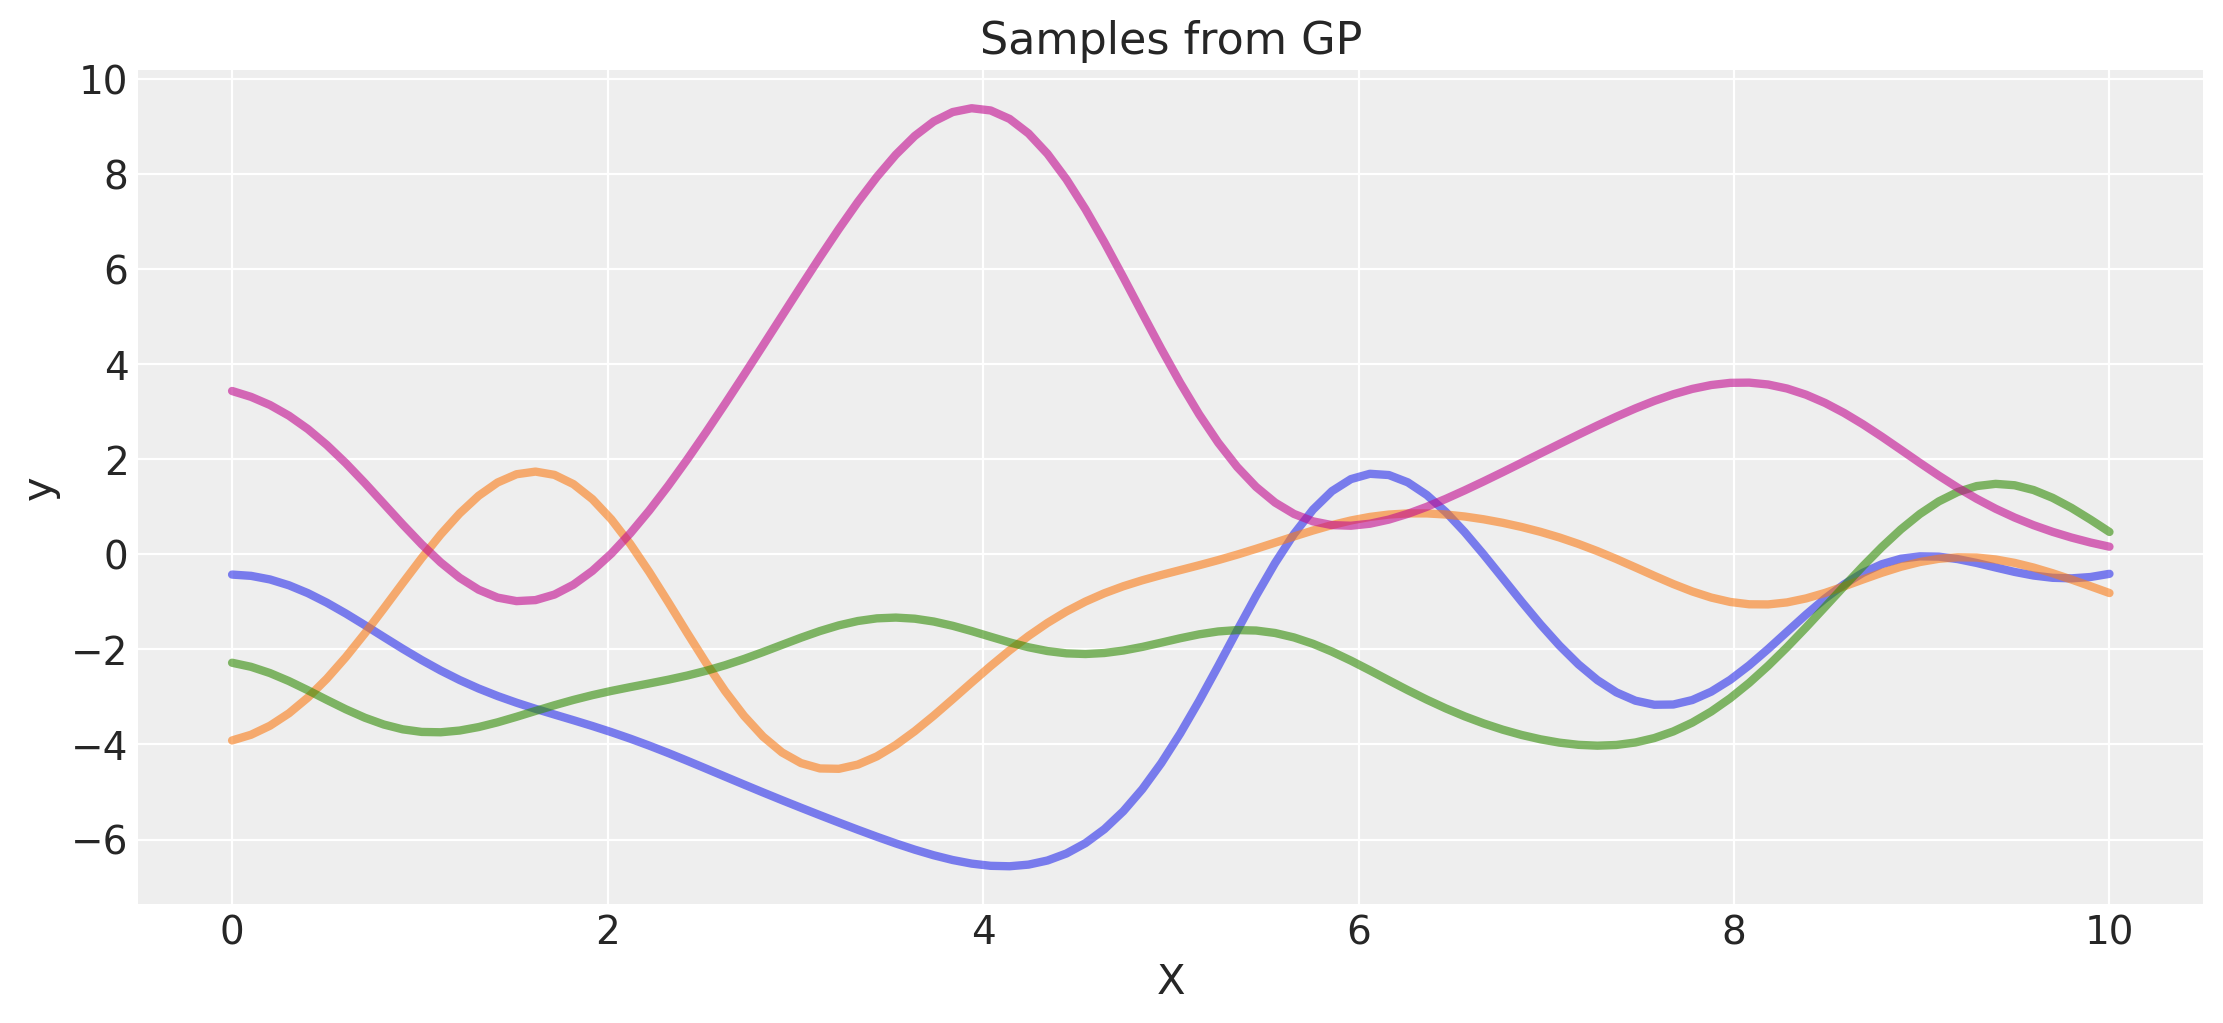

In [44]:
n = 100  # The number of data points
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true ** 2 * pm.gp.cov.ExpQuad(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

## Plot samples from TP prior
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
for _ in range(4):
    rv = pm.MvStudentT.dist(mu=mean_func(X).eval(), cov=cov_func(X).eval(), nu=3)
    ax.plot(X.flatten(), rv.eval(), lw=3, alpha=0.6)
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.set_title("Samples from TP with DoF=3")


fig = plt.figure(figsize=(11, 5))
ax = fig.gca()
for _ in range(4):
    rv = pm.MvNormal.dist(mu=mean_func(X).eval(), cov=cov_func(X).eval())
    ax.plot(X.flatten(), rv.eval(), lw=3, alpha=0.6)
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.set_title("Samples from GP");

## Data generated by a two dimensional T process with normal noise

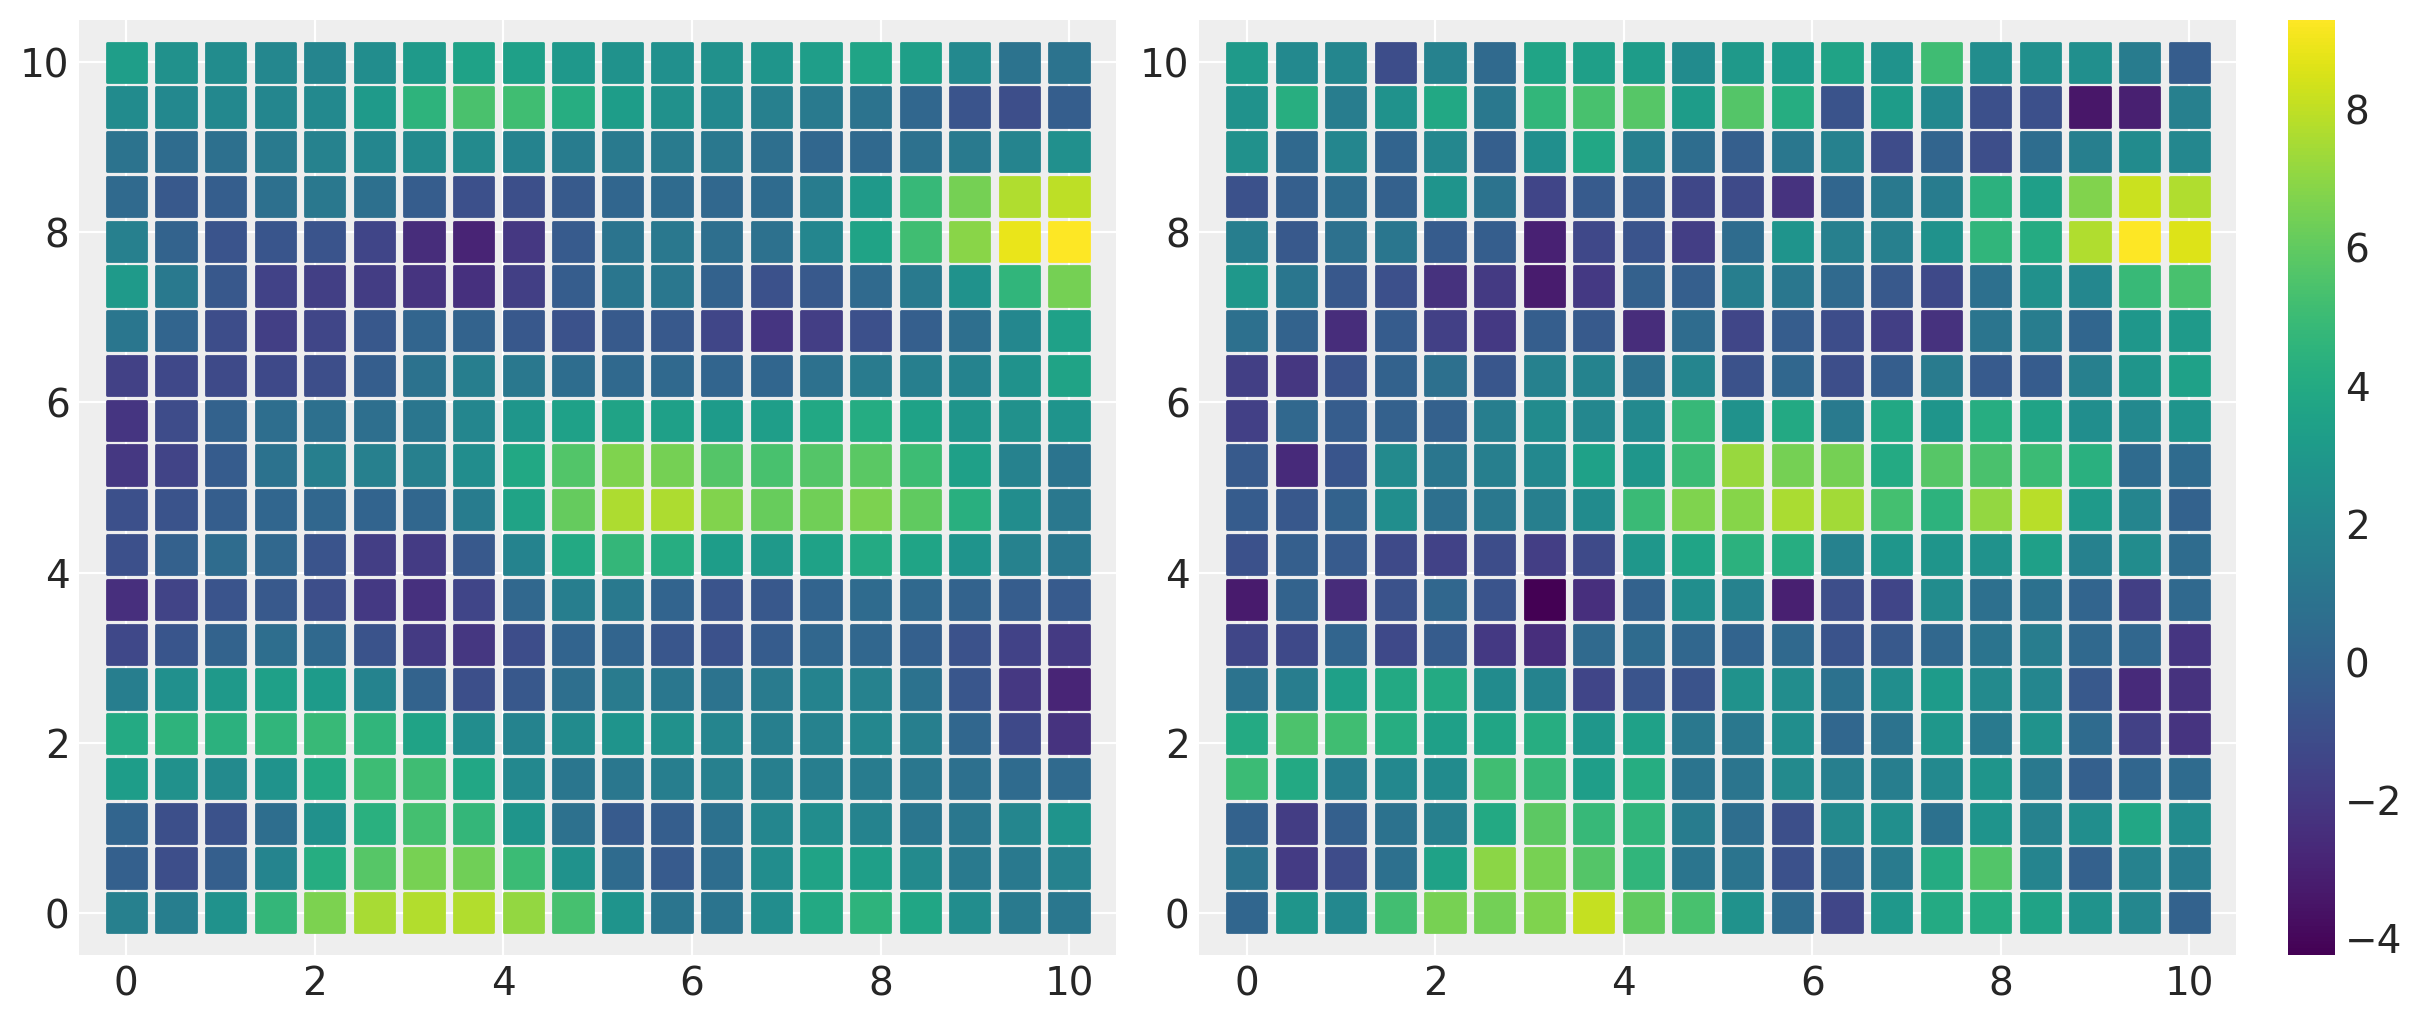

In [45]:
xx, yy = np.meshgrid(np.linspace(0, 1, 20), np.linspace(0, 1, 20))
X = 10*np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
n = X.shape[0]

# Define the true covariance function and its parameters
ℓ_true = [1.25, 0.75]
η_true = 1
cov_func = η_true ** 2 * pm.gp.cov.ExpQuad(2, ℓ_true) + 1.0

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = pm.MvStudentT.dist(mu=mean_func(X).eval(), cov=cov_func(X).eval(), nu=3, rng=rng).eval()
y = 1.0 * rng.get_value().normal(size=n) + f_true

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs = axs.flatten()

axs[0].scatter(X[:, 0], X[:, 1], c=f_true, s=200, marker='s', vmin=np.min(y), vmax=np.max(y))
m = axs[1].scatter(X[:, 0], X[:, 1], c=y, s=200, marker='s', vmin=np.min(y), vmax=np.max(y))

plt.colorbar(m);
#ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
#ax.plot(X, y, "ok", ms=3, label="Data")
#ax.set_xlabel("X")
#ax.set_ylabel("y")
#plt.legend();

In [46]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=1, size=2)
    eta = pm.HalfNormal("eta", sd=2)
    cov = eta**2 * pm.gp.cov.ExpQuad(2, ell) + 1.0

    nu = pm.Gamma("nu", alpha=2, beta=0.1)
    tp = pm.gp.TP(cov_func=cov, nu=nu)
    f = tp.prior("f", X=X)

    sigma = pm.HalfNormal("sigma", sd=2)
    y_ = pm.Normal("y", mu=f, sd=sigma, observed=y)

    tr = pm.sample(1000, chains=3, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [ell, eta, nu, f_rotated_, sigma]


/home/bill/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bill/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Sampling 1 chain for 94 tune and 0 draw iterations (94 + 0 draws total) took 192 seconds.
No posterior samples. Unable to run convergence checks


In [47]:
az.plot_trace(tr, var_names=["eta", "ell", "nu"]);

ValueError: Can not extract posterior from Inference data with groups:
	> observed_data! See /home/bill/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/data/converters.py for other conversion utilities.

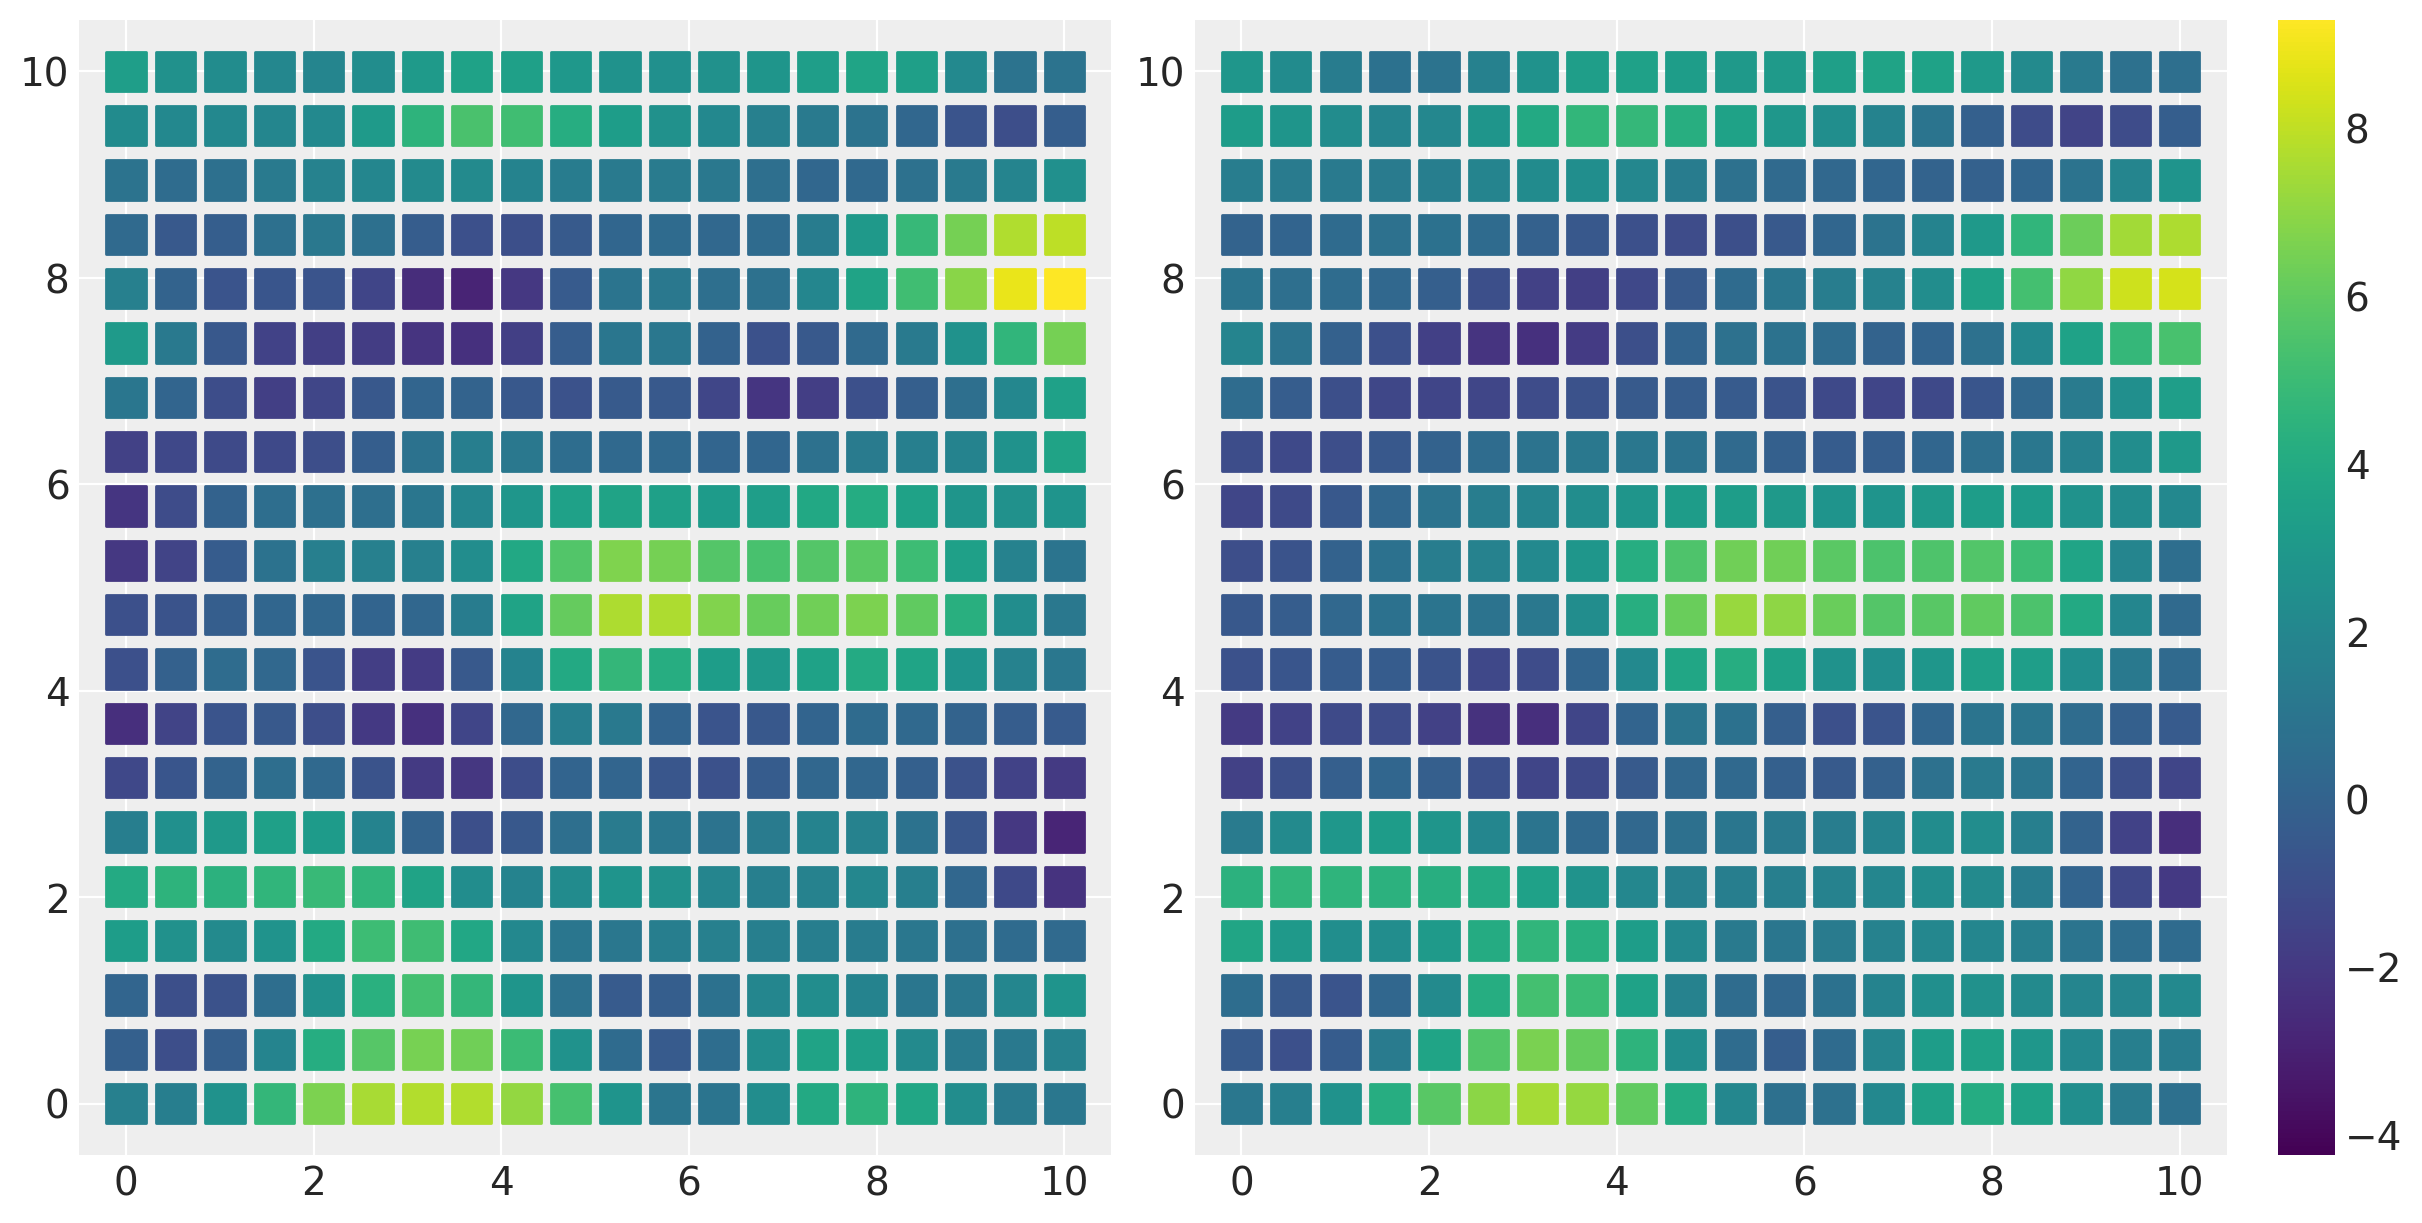

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.flatten()

axs[0].scatter(X[:, 0], X[:, 1], c=f_true, s=200, marker='s', vmin=np.min(y), vmax=np.max(y))

fhat = np.mean(tr.posterior.f.stack({'f': ['chain', 'draw']}), axis=1)
m=axs[1].scatter(X[:, 0], X[:, 1], c=fhat, s=200, vmin=np.min(y), vmax=np.max(y), marker='s');
plt.colorbar(m);
#plt.scatter(X[:, 0], X[:, 1], c=y, s=100, label="Data")

In [28]:
xx, yy = np.meshgrid(np.linspace(1, 1.5, 10), np.linspace(0, 1, 20))
X_new = 10*np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

# add the GP conditional to the model, given the new X values
with model:
    f_pred = tp.conditional("f_pred", X_new, jitter=1e-6)

In [29]:
# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(tr, var_names=['f_pred'], samples=500)

/tmp/ipykernel_32493/3181521800.py:3: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  pred_samples = pm.sample_posterior_predictive(tr, var_names=['f_pred2'], samples=500)


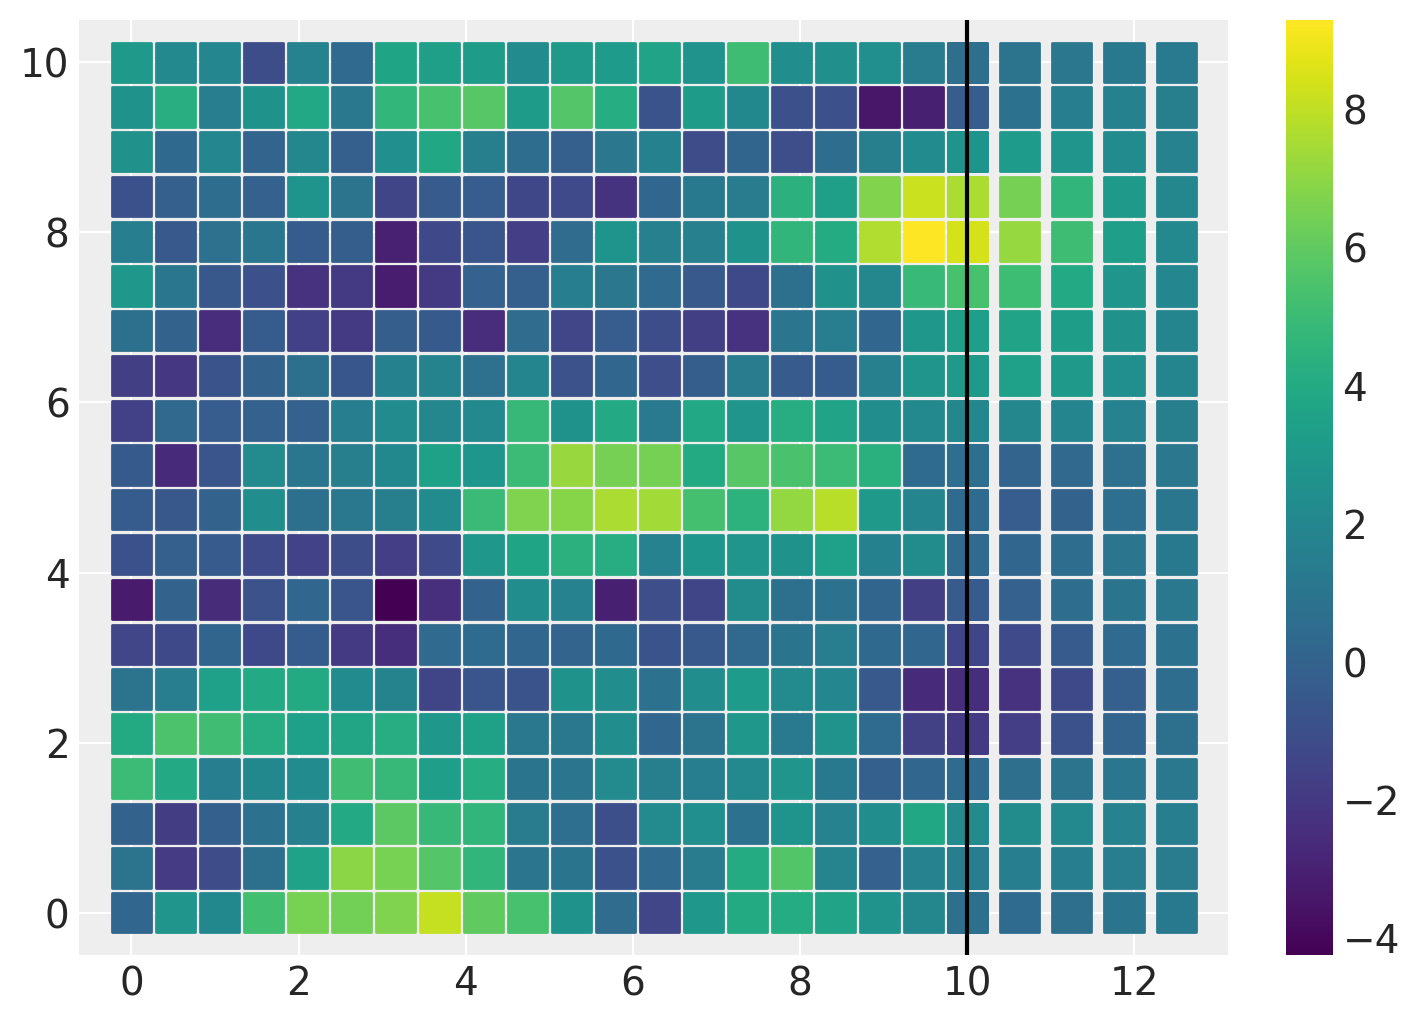

In [38]:
fig = plt.figure(figsize=(9, 5))
ax = fig.gca()

ax.scatter(X[:, 0], X[:, 1], c=y, s=200, marker='s', vmin=np.min(y), vmax=np.max(y))

fhat = np.mean(pred_samples['f_pred'], axis=0)
m=ax.scatter(X_new[:, 0], X_new[:, 1], c=fhat, s=200, vmin=np.min(y), vmax=np.max(y), marker='s');

ax.axvline(x=(X_new[:, 0].min() + X[:, 0].max()) / 2, color='k')
plt.colorbar(m);

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

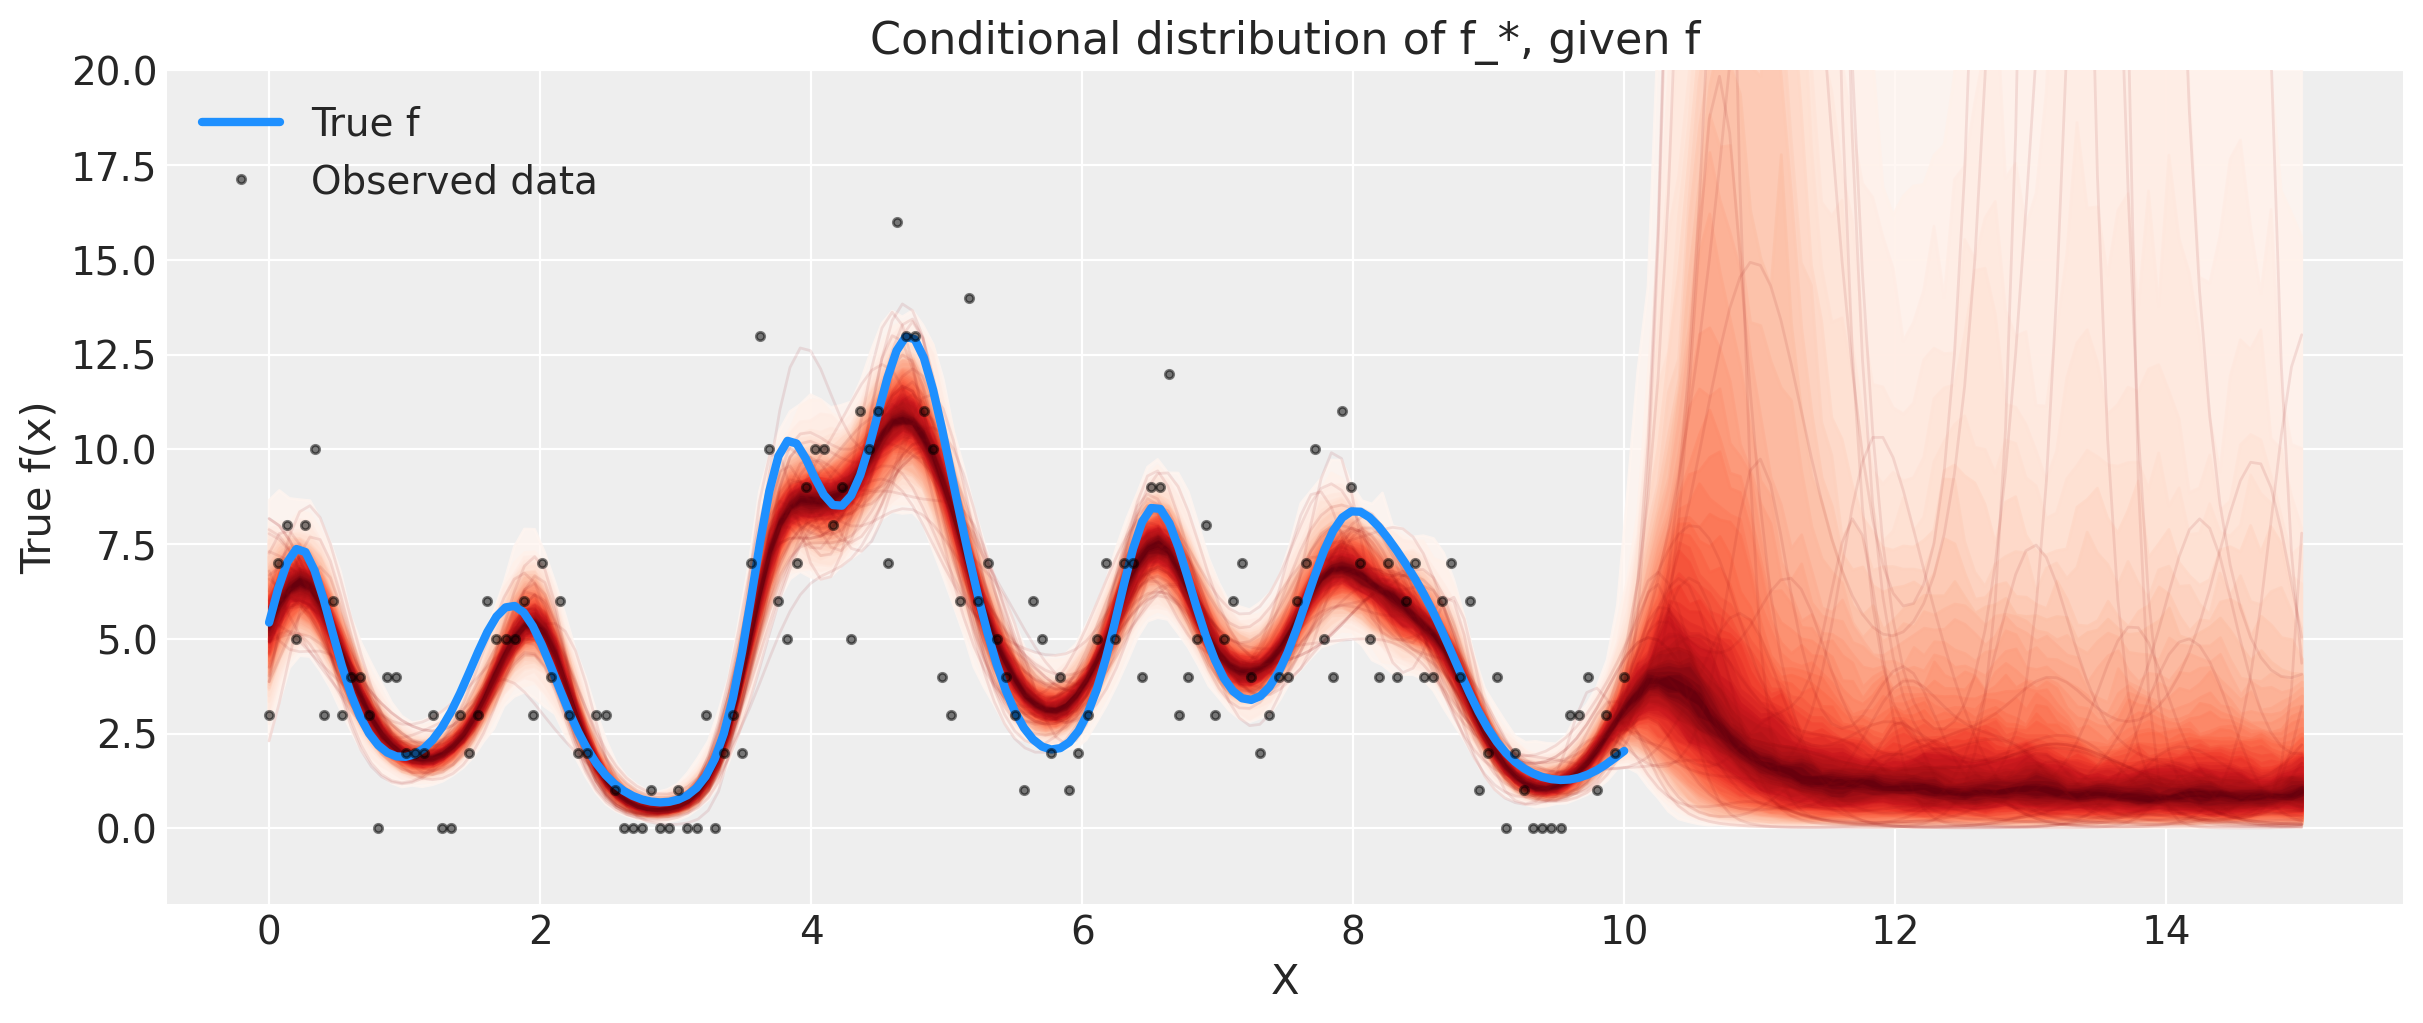

In [75]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
from pymc.gp.util import plot_gp_dist

plot_gp_dist(ax, np.exp(pred_samples["f_pred"]), X_new)
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(X, y, "ok", ms=3, alpha=0.5, label="Observed data")
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.ylim([-2, 20])
plt.title("Conditional distribution of f_*, given f")
plt.legend();

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w

pymc3 3.8
arviz 0.8.3
numpy 1.17.5
last updated: Thu Jun 11 2020 

CPython 3.8.2
IPython 7.11.0
watermark 2.0.2
